	Initialization Time: 0.462866067886
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Finishing step: 35000
Finishing step: 40000
Total Time 14.3104858398
Pre loop Time 0.000800848007202
Inner loop time 13.7368605137
Outer loop time 0.260982036591


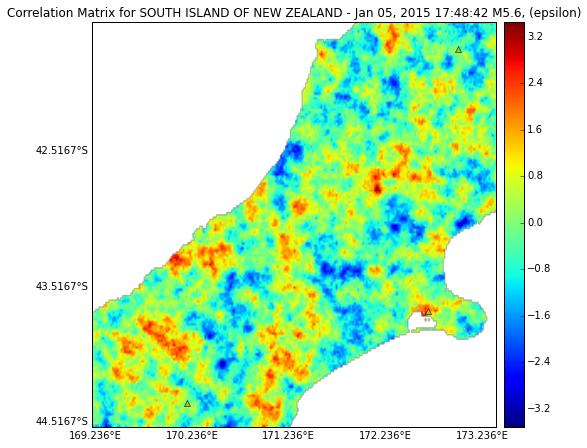

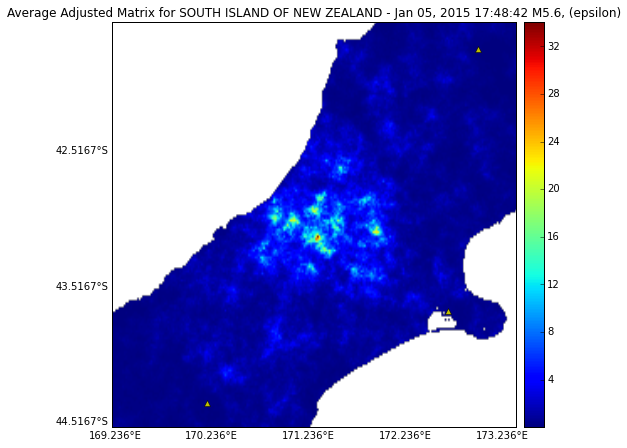

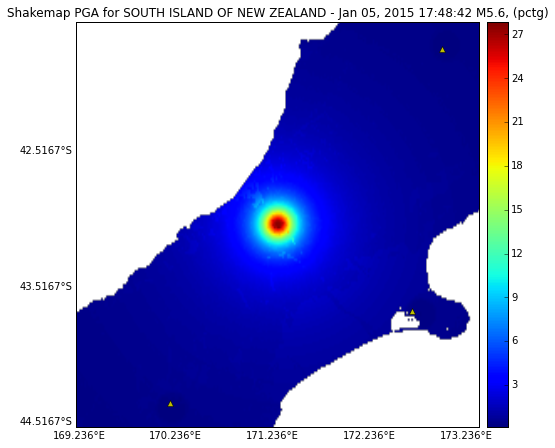

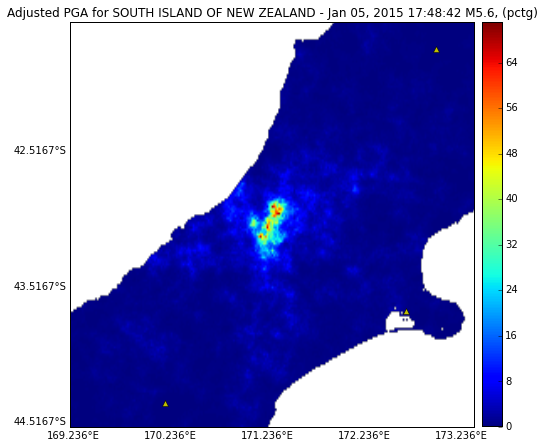

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from neicio.readstation import readStation
from neicio.shake import ShakeGrid
from neicio.gmt import GMTGrid
import time
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from Correlation.setup import initialize
from Correlation.loop import main
from Correlation.realizations import realizations
from Correlation.testing_code import run
from Correlation.plotting import plot

# Variable of interest                                                                                                                                                                                                        
voi = 'PGA'

# Specify the radius of interest                                                                                                                                                                                              
r = 6

# Specify number of realizations
num_realizations = 1

# Get shakemap for desired variable, PGA, uncertainty grid and stationdata                                                                                                                                                    
# Selected Stations: Units in pctg                                                                                                                                                                                            
shakemap = ShakeGrid('/Users/sverros/Documents/shakemaps/NZHok/grid.xml', variable = '%s' % voi)

# Uncertainty Data: Units in ln(pctg)                                                                                                                                                                                         
uncertainty = ShakeGrid('/Users/sverros/Documents/shakemaps/NZHok/uncertainty.xml', variable= 'STD%s' % voi)

# Station Data: Units in pctg                                                                                                                                                                                                 
stationlist = '/Users/sverros/Documents/shakemaps/NZHok/stationlist.xml'
stationdata = readStation(stationlist)

# Used for plotting                                                                                                                                                                                                           
topofile = '/Users/sverros/Documents/etopo1_bed_g_f4.grd'

# Sets up grid spacing, site collections, and other data values
# optional parameters: dm, dn, the grid discritization defaulting to 1
variables = initialize(shakemap, uncertainty, stationdata)

# Calculate the random array, stored for testing
rand = np.random.randn(variables['N']*variables['M'])

# Main program for computing spatial correlation
# Output is a dictionary with the following keys
#     cor- grid of spatially correlated epsilon                                                                                                                                
#     data- grid of ShakeMap data                                                                                                                                              
#     data_new- data with added spatial correlation                                                                                                                            
#     grid_arr- array for storing grid indices for multiple realizations                                                                                                       
#     mu_arr- array for storing Sig21.T*Sig11inv for multiple realizations                                                                                                     
#     sigma_arr- array for storing sigma for multiple realizations  
out = main(variables, r, voi, rand)

# Calculate multiple realizations
ACCUM_ARRAY = realizations(num_realizations, variables['N'], variables['M'], out['grid_arr'], 
                           out['mu_arr'], out['sigma_arr'], variables['uncertaintydata'], out['data'])

plot(out, variables, voi, shakemap, stationdata, topofile, ACCUM_ARRAY)

In [3]:
# Testing, computes output for varying R values

rand = np.random.randn(variables['N']*variables['M'])

R = [5, 10, 15, 20, 25, 30]

data_NEW = np.zeros([variables['M']*variables['N'], np.size(R)])

for k in range(0,np.size(R)):
    out = run(R[k], rand, shakemap, uncertainty, stationdata, variables, voi)
    data_NEW[:,k] = np.reshape(out, [variables['N']*variables['M']])


In [ ]:
print 'R, R+5'
for k in range(0,np.size(R)-1):
    print 'k, mean difference', np.mean(abs(data_NEW[:,k] - data_NEW[:,k+1]))
    print 'k, t-value, p-value', scipy.stats.ttest_ind(data_NEW[:,k], data_NEW[:,k+1])
    
print 'R, R = 35'
for k in range(0,np.size(R)-1):
    print 'max difference', max(data_NEW[:,k] - data_NEW[:,np.size(R)-1])
    print 'mean difference', np.mean(abs(data_NEW[:,k] - data_NEW[:,np.size(R)-1]))
    print 't-value, p-value', scipy.stats.ttest_ind(data_NEW[:,k], data_NEW[:,np.size(R)-1])